<a href="https://colab.research.google.com/github/Dipeshtamboli/Interactive-GradCAM/blob/master/Interactive_GradCAM_ImageNet.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import json
import torch.nn as nn
import os
import torch.nn.functional as F
import pdb
import argparse
import cv2
import numpy as np
import torch
from torch.autograd import Function
from torchvision import models

class FeatureExtractor():
    """ Class for extracting activations and 
    registering gradients from targetted intermediate layers """

    def __init__(self, model, target_layers):
        self.model = model
        self.target_layers = target_layers
        self.gradients = []

    def save_gradient(self, grad):
        self.gradients.append(grad)

    def __call__(self, x):
        outputs = []
        self.gradients = []
        for name, module in self.model._modules.items():
            x = module(x)
            if name in self.target_layers:
                x.register_hook(self.save_gradient)
                outputs += [x]
        return outputs, x


class ModelOutputs():
    def __init__(self, model, feature_module, target_layers):
        self.model = model
        self.feature_module = feature_module
        self.feature_extractor = FeatureExtractor(self.feature_module, target_layers)

    def get_gradients(self):
        return self.feature_extractor.gradients

    def __call__(self, x):
        target_activations = []
        for name, module in self.model._modules.items():
            if module == self.feature_module:
                target_activations, x = self.feature_extractor(x)
            elif "avgpool" in name.lower():
                x = module(x)
                x = x.view(x.size(0),-1)
            else:
                x = module(x)
        
        return target_activations, x



def preprocess_image(img):
    means = [0.485, 0.456, 0.406]
    stds = [0.229, 0.224, 0.225]

    preprocessed_img = img.copy()[:, :, ::-1]
    for i in range(3):
        preprocessed_img[:, :, i] = preprocessed_img[:, :, i] - means[i]
        preprocessed_img[:, :, i] = preprocessed_img[:, :, i] / stds[i]
    preprocessed_img = \
        np.ascontiguousarray(np.transpose(preprocessed_img, (2, 0, 1)))
    preprocessed_img = torch.from_numpy(preprocessed_img)
    preprocessed_img.unsqueeze_(0)
    input = preprocessed_img.requires_grad_(True)
    return input

def create_dir(path_to_img):
    directory = os.path.join(*path_to_img.split('/')[:-1]) 
    if not os.path.exists(directory):
        os.makedirs(directory)    

def save_img(image_path, img, if_range_0_1=False):
    create_dir(image_path)
    if if_range_0_1:
        cv2.imwrite(image_path, np.uint8(255 * img))
    else:
        cv2.imwrite(image_path, (img))

def show_cam_on_image(img, mask, img_path):
    heatmap = cv2.applyColorMap(np.uint8(255 * mask), cv2.COLORMAP_JET)
    heatmap = np.float32(heatmap) / 255
    cam = heatmap + np.float32(img)
    cam = cam / np.max(cam)
    # cv2.imwrite("cam.jpg", np.uint8(255 * cam))
    # save_img(img_path,cam,if_range_0_1=True)
    return np.uint8(255 * cam)


class GradCam:
    def __init__(self, model, feature_module, target_layer_names, use_cuda):
        self.model = model
        self.feature_module = feature_module
        self.model.eval()
        self.cuda = use_cuda
        if self.cuda:
            self.model = model.cuda()

        self.extractor = ModelOutputs(self.model, self.feature_module, target_layer_names)

    def forward(self, input):
        return self.model(input)

    def __call__(self, input, index=None):
        if self.cuda:
            features, output = self.extractor(input.cuda())
        else:
            features, output = self.extractor(input)

        if index == None:
            index = np.argmax(output.cpu().data.numpy())

        one_hot = np.zeros((1, output.size()[-1]), dtype=np.float32)
        one_hot[0][index] = 1
        one_hot = torch.from_numpy(one_hot).requires_grad_(True)
        if self.cuda:
            one_hot = torch.sum(one_hot.cuda() * output)
        else:
            one_hot = torch.sum(one_hot * output)

        self.feature_module.zero_grad()
        self.model.zero_grad()
        one_hot.backward(retain_graph=True)

        grads_val = self.extractor.get_gradients()[-1].cpu().data.numpy()

        target = features[-1]
        target = target.cpu().data.numpy()[0, :]

        weights = np.mean(grads_val, axis=(2, 3))[0, :]
        cam = np.zeros(target.shape[1:], dtype=np.float32)

        for i, w in enumerate(weights):
            cam += w * target[i, :, :]

        cam = np.maximum(cam, 0)
        cam = cv2.resize(cam, input.shape[2:])
        cam = cam - np.min(cam)
        cam = cam / np.max(cam)
        return cam


class GuidedBackpropReLU(Function):

    @staticmethod
    def forward(self, input):
        positive_mask = (input > 0).type_as(input)
        output = torch.addcmul(torch.zeros(input.size()).type_as(input), input, positive_mask)
        self.save_for_backward(input, output)
        return output

    @staticmethod
    def backward(self, grad_output):
        input, output = self.saved_tensors
        grad_input = None

        positive_mask_1 = (input > 0).type_as(grad_output)
        positive_mask_2 = (grad_output > 0).type_as(grad_output)
        grad_input = torch.addcmul(torch.zeros(input.size()).type_as(input),
                                   torch.addcmul(torch.zeros(input.size()).type_as(input), grad_output,
                                                 positive_mask_1), positive_mask_2)

        return grad_input


class GuidedBackpropReLUModel:
    def __init__(self, model, use_cuda):
        self.model = model
        self.model.eval()
        self.cuda = use_cuda
        if self.cuda:
            self.model = model.cuda()

        def recursive_relu_apply(module_top):
            for idx, module in module_top._modules.items():
                recursive_relu_apply(module)
                if module.__class__.__name__ == 'ReLU':
                    module_top._modules[idx] = GuidedBackpropReLU.apply
                
        # replace ReLU with GuidedBackpropReLU
        recursive_relu_apply(self.model)

    def forward(self, input):
        return self.model(input)

    def __call__(self, input, index=None):
        if self.cuda:
            output = self.forward(input.cuda())
        else:
            output = self.forward(input)

        output = output[0]
        if index == None:
            # pdb.set_trace()
            index = np.argmax(output.cpu().data.numpy())

        one_hot = np.zeros((1, output.size()[-1]), dtype=np.float32)
        one_hot[0][index] = 1
        one_hot = torch.from_numpy(one_hot).requires_grad_(True)
        if self.cuda:
            one_hot = torch.sum(one_hot.cuda() * output)
        else:
            one_hot = torch.sum(one_hot * output)

        # self.model.features.zero_grad()
        # self.model.classifier.zero_grad()
        one_hot.backward(retain_graph=True)

        output = input.grad.cpu().data.numpy()
        output = output[0, :, :, :]

        return output

def deprocess_image(img):
    """ see https://github.com/jacobgil/keras-grad-cam/blob/master/grad-cam.py#L65 """
    img = img - np.mean(img)
    img = img / (np.std(img) + 1e-5)
    img = img * 0.1
    img = img + 0.5
    img = np.clip(img, 0, 1)
    return np.uint8(img*255)

# Model modified-VGG16 architecture

In [2]:
import torchvision.models as models
# resnet18 = models.resnet18()
# alexnet = models.alexnet()
# vgg16 = models.vgg16()
# squeezenet = models.squeezenet1_0()
# densenet = models.densenet161()
# inception = models.inception_v3()
# googlenet = models.googlenet()
# shufflenet = models.shufflenet_v2_x1_0()
mobilenet = models.mobilenet_v2()
# resnext50_32x4d = models.resnext50_32x4d()
# wide_resnet50_2 = models.wide_resnet50_2()
# mnasnet = models.mnasnet1_0()

### Downloading dictionary for index and corresponding class names 
### Downloading some sample input images from the following GitHub repo
[GradCAM GitHub repo](https://github.com/Dipeshtamboli/Interactive-GradCAM)   
Check lookup dictionary for the class name and their index [here](https://github.com/Dipeshtamboli/Interactive-GradCAM/blob/master/imagenet_labels.json)

In [3]:
# Dictionary for index and corresponding class names
!wget https://raw.githubusercontent.com/Dipeshtamboli/Interactive-GradCAM/master/imagenet_labels.json
# Sample input image contaitnng  teddy and person
!wget https://github.com/Dipeshtamboli/Interactive-GradCAM/raw/master/input_images/teddy_person.jpg
# image containing persons, bench, bear
!wget https://github.com/Dipeshtamboli/Interactive-GradCAM/raw/master/input_images/bear_bench.jpg
# horse picture, pc, bed
!wget https://github.com/Dipeshtamboli/Interactive-GradCAM/raw/master/input_images/horse_px.jpg
# man, bike, car
!wget https://github.com/Dipeshtamboli/Interactive-GradCAM/raw/master/input_images/man_bike.jpg
# me ;)
!wget https://dipeshtamboli.github.io/images/author.jpg

--2020-08-08 15:58:51--  https://raw.githubusercontent.com/Dipeshtamboli/Interactive-GradCAM/master/imagenet_labels.json
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 151.101.0.133, 151.101.64.133, 151.101.128.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|151.101.0.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 32564 (32K) [text/plain]
Saving to: ‘imagenet_labels.json’

imagenet_labels.jso 100%[===================>]  31.80K  --.-KB/s    in 0.01s   

2020-08-08 15:58:51 (2.95 MB/s) - ‘imagenet_labels.json’ saved [32564/32564]

--2020-08-08 15:58:53--  https://github.com/Dipeshtamboli/Interactive-GradCAM/raw/master/input_images/teddy_person.jpg
Resolving github.com (github.com)... 140.82.112.3
Connecting to github.com (github.com)|140.82.112.3|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://raw.githubusercontent.com/Dipeshtamboli/Interactive-GradCAM/master/input_image

In [4]:
from google.colab.patches import cv2_imshow
def show_gradcam(path,target_class=None):
    imagenet_labels = open("imagenet_labels.json", 'rb')
    label_names = json.load(open("imagenet_labels.json", 'rb'))

    model = models.resnet50(pretrained=True)
    model_name = "resnet50"
    path = path.strip()
    img_path = path
    img = cv2.imread(img_path, 1)
    img = np.float32(cv2.resize(img, (224, 224))) / 255
    input = preprocess_image(img)
    grad_cam = GradCam(model=model, feature_module=model.layer4,target_layer_names=["2"], use_cuda=torch.cuda.is_available())
    model_output = model(input.cuda())
    predictions = torch.sigmoid(model_output[0]).cpu().detach().numpy()
    rounded_preds = np.round(predictions,5)
    top5_arg = np.argsort(predictions)[-5:]
    confidence = predictions[top5_arg]
    # If None, returns the map for the highest scoring category.
    # Otherwise, targets the requested index.
    if target_class:
        target_index = target_class
        target_class = label_names[str(target_index)].split(',')[0]
    else:
        target_index = None
        target_class = label_names[str(top5_arg[4])].split(',')[0]
    print("target_class: {}".format(target_class))
    mask = grad_cam(input, target_index)
    gb_model = GuidedBackpropReLUModel(model=model, use_cuda=torch.cuda.is_available())
    gb = gb_model(input, index=target_index)
    gb = gb.transpose((1, 2, 0))
    cam_mask = cv2.merge([mask, mask, mask])
    cam_gb = deprocess_image(cam_mask*gb)
    gb = deprocess_image(gb)
    cam = show_cam_on_image(img, mask, "cam_vis/cam")

    font = cv2.FONT_HERSHEY_SIMPLEX
    text_img = np.zeros(gb.shape)
    text_img = cv2.putText(text_img,model_name,(10,50), font, 0.8,(255,255,255),1,cv2.LINE_AA)
    text_img = cv2.putText(text_img,"target_class: {}".format(target_class),(20//2,150//2), font, 0.5,(255,255,255),1,cv2.LINE_AA)
    text_img = cv2.putText(text_img,'{}: {}'.format(label_names[str(top5_arg[0])],str(rounded_preds[top5_arg[0]])[:5]),(50//2,400//2), font, 0.5,(255,255,255),1,cv2.LINE_AA)
    text_img = cv2.putText(text_img,'{}: {}'.format(label_names[str(top5_arg[1])],str(rounded_preds[top5_arg[1]])[:5]),(50//2,350//2), font, 0.5,(255,255,255),1,cv2.LINE_AA)
    text_img = cv2.putText(text_img,'{}: {}'.format(label_names[str(top5_arg[2])],str(rounded_preds[top5_arg[2]])[:5]),(50//2,300//2), font, 0.5,(255,255,255),1,cv2.LINE_AA)
    text_img = cv2.putText(text_img,'{}: {}'.format(label_names[str(top5_arg[3])],str(rounded_preds[top5_arg[3]])[:5]),(50//2,250//2), font, 0.5,(255,255,255),1,cv2.LINE_AA)
    text_img = cv2.putText(text_img,'{}: {}'.format(label_names[str(top5_arg[4])],str(rounded_preds[top5_arg[4]])[:5]),(50//2,200//2), font, 0.5,(255,255,255),1,cv2.LINE_AA)
    output = np.concatenate((np.uint8(255 * img), gb, cam, cam_gb, text_img), axis=1)
    save_img('combined_output/{}'.format(path), output)
    
    cv2_imshow(output)    
    print("-----------------------------")

### Model is trained on ImageNet dataset.
### Choose any class for checking the corresponding GradCAM visualization
Check lookup dictionary for the class name and their index [here](https://github.com/Dipeshtamboli/Interactive-GradCAM/blob/master/imagenet_labels.json)



Downloading: "https://download.pytorch.org/models/resnet50-19c8e357.pth" to /root/.cache/torch/hub/checkpoints/resnet50-19c8e357.pth



target_class: folding chair


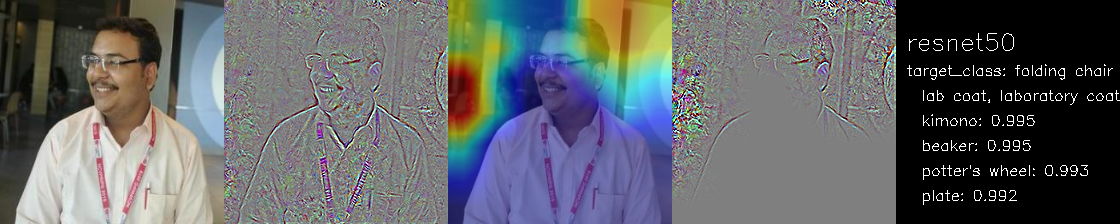

-----------------------------
target_class: ballpoint


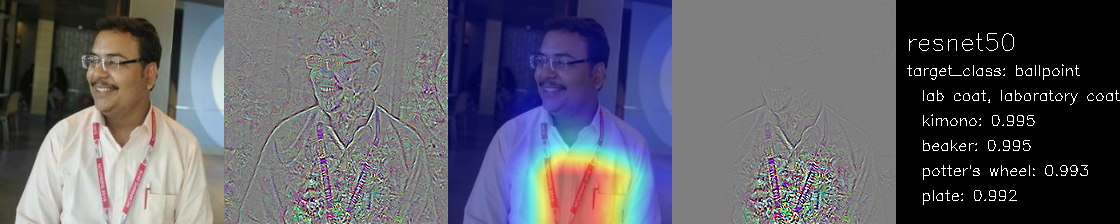

-----------------------------
target_class: teddy


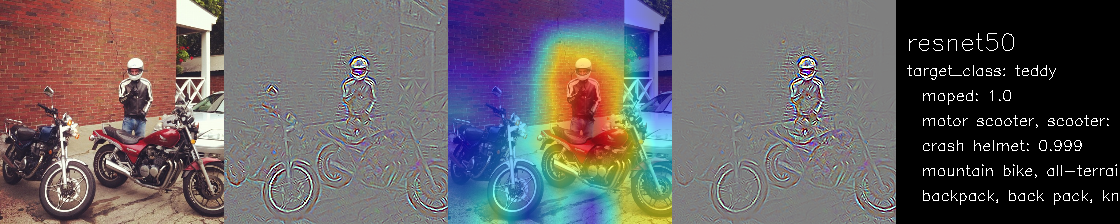

-----------------------------
target_class: crash helmet


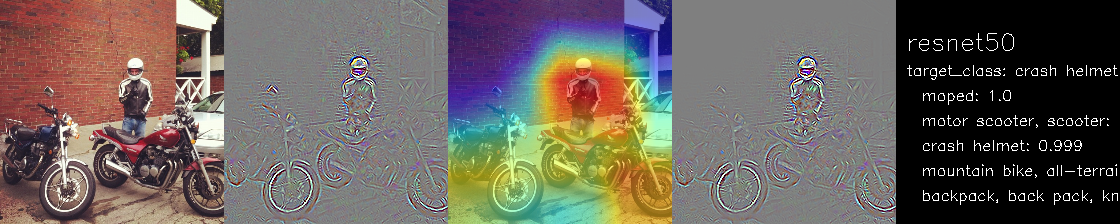

-----------------------------
target_class: moped


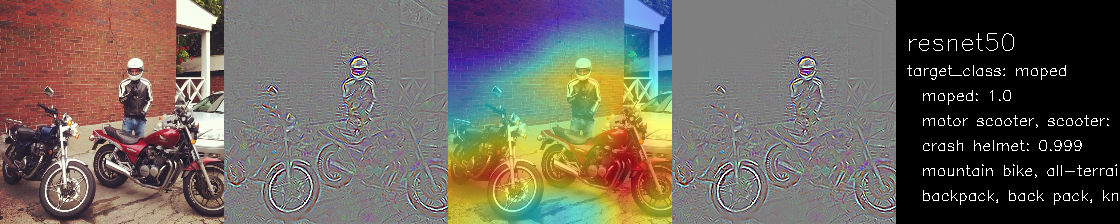

-----------------------------
target_class: teddy


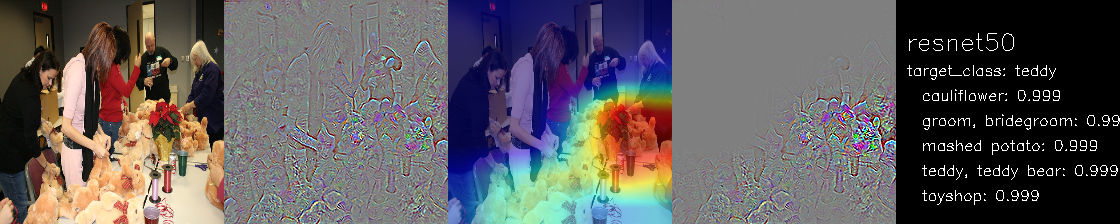

-----------------------------
target_class: cauliflower


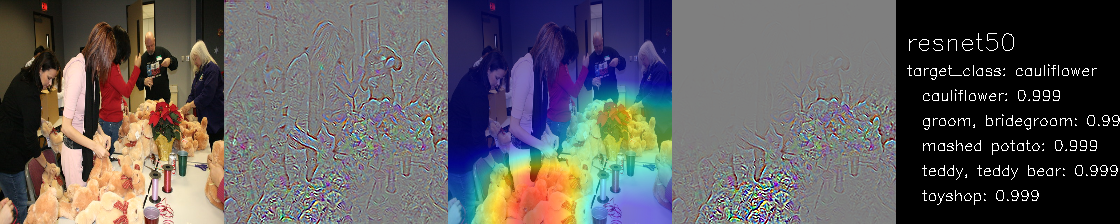

-----------------------------


In [5]:
if __name__ == '__main__':
    show_gradcam("author.jpg",target_class=559) #559 -> folding chair
    show_gradcam("author.jpg",target_class=418) #418 -> Ballpoint pen
    show_gradcam("man_bike.jpg",target_class=850) #850 -> Teddy
    show_gradcam("man_bike.jpg",target_class=518) #518 -> crashed helmet
    show_gradcam("man_bike.jpg",target_class=None) 
    show_gradcam("teddy_person.jpg",target_class=850) #850 -> Teddy
    show_gradcam("teddy_person.jpg",target_class=None)
    
